# 3 approaches to creating time-related features for ML models

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklego.preprocessing import RepeatingBasisFunction

# settings
plt.style.use("seaborn")
sns.set_palette("colorblind")

%matplotlib inline

In [2]:
%config InlineBackend.figure_format = "retina"

## Generating data

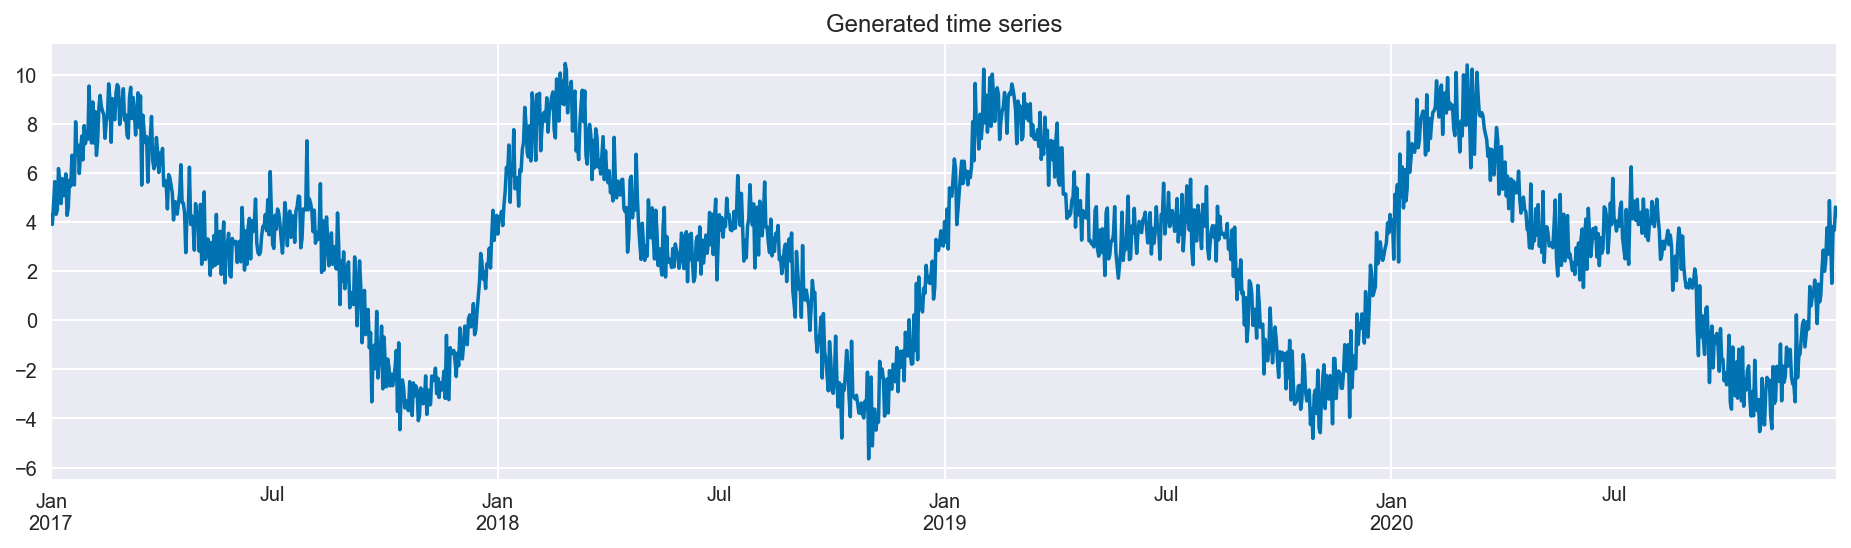

In [3]:
# for reproducibility
np.random.seed(42)

# generate the DataFrame with dates
range_of_dates = pd.date_range(start="2017-01-01", 
                               end="2020-12-30")
X = pd.DataFrame(index=range_of_dates)

# create a sequence of day numbers
X["day_nr"] = range(len(X))
X["day_of_year"] = X.index.day_of_year

# generate the components of the target
signal_1 = 3 + 4 * np.sin(X["day_nr"] / 365 * 2 * np.pi)
signal_2 = 3 * np.sin(X["day_nr"] / 365 * 4 * np.pi + 365/2)
noise = np.random.normal(0, 0.85, len(X))

# combine them to get the target series
y = signal_1 + signal_2 + noise

# plot
y.plot(figsize=(16,4), title="Generated time series");

In [4]:
X

,day_nr,day_of_year
2017-01-01,0,1
2017-01-02,1,2
2017-01-03,2,3
2017-01-04,3,4
2017-01-05,4,5
...,...,...
2020-12-26,1455,361
2020-12-27,1456,362
2020-12-28,1457,363
2020-12-29,1458,364


In [5]:
# create a DataFrame to store the ground truth and the fitted values
results_df = y.to_frame()
results_df.columns = ["actuals"]
results_df.head()

,actuals
2017-01-01,4.273237
2017-01-02,3.900877
2017-01-03,4.735163
2017-01-04,5.644148
2017-01-05,4.314070


## Creating date-related features 

### Approach 1: Dummy variables

In [16]:
X_1 = pd.DataFrame(
    data=pd.get_dummies(X.index.month, drop_first=True, prefix="month")
)
X_1.index = X.index
X_1

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2017-01-01,0,0,0,0,0,0,0,0,0,0,0
2017-01-02,0,0,0,0,0,0,0,0,0,0,0
2017-01-03,0,0,0,0,0,0,0,0,0,0,0
2017-01-04,0,0,0,0,0,0,0,0,0,0,0
2017-01-05,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,0,0,0,0,0,0,0,0,0,0,1
2020-12-27,0,0,0,0,0,0,0,0,0,0,1
2020-12-28,0,0,0,0,0,0,0,0,0,0,1
2020-12-29,0,0,0,0,0,0,0,0,0,0,1


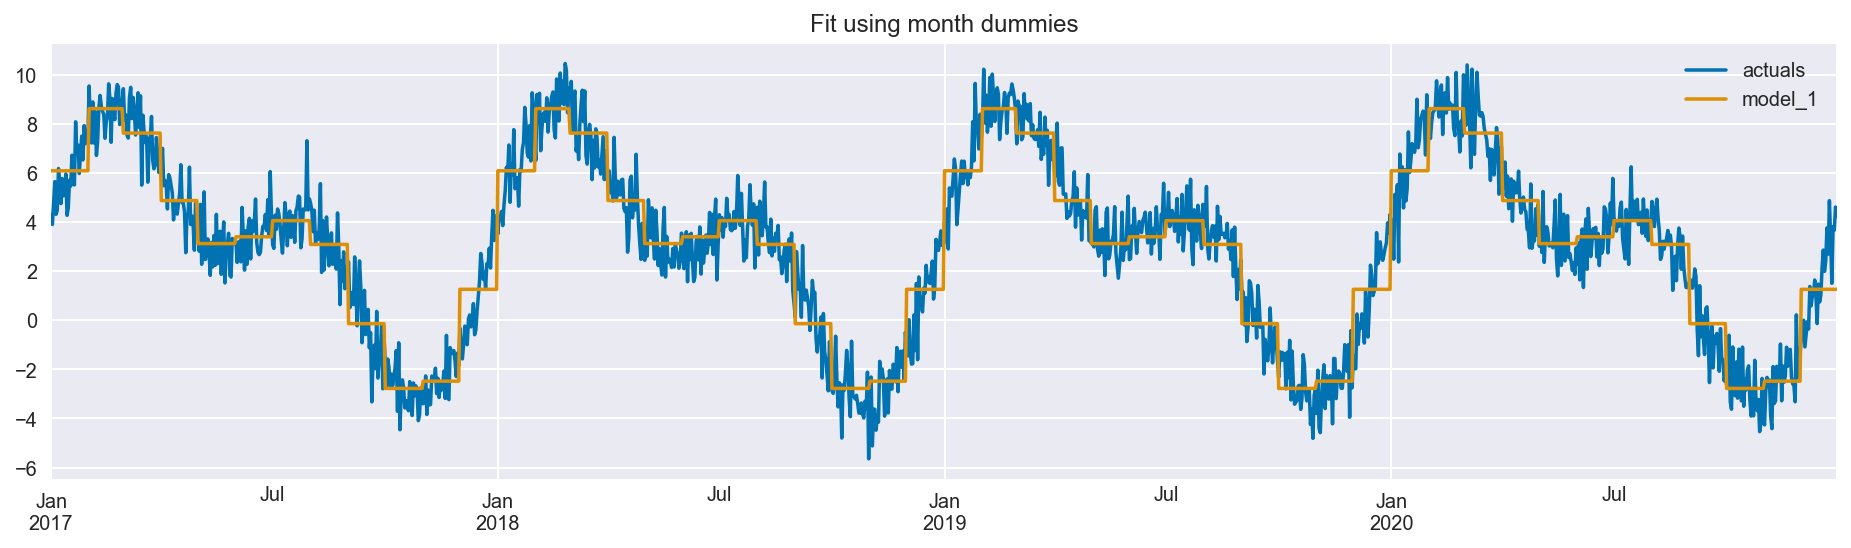

In [17]:
results_df["model_1"] = LinearRegression().fit(X_1, y).predict(X_1)
results_df[["actuals", "model_1"]].plot(figsize=(16,4), 
                                        title="Fit using month dummies");

### Approach 2: Cyclical encoding with sine/cosine transformation

In [18]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [19]:
X_2 = X.copy()
X_2["month"] = X_2.index.month

In [20]:
X_2["month_sin"] = sin_transformer(12).fit_transform(X_2)["month"]
X_2["month_cos"] = cos_transformer(12).fit_transform(X_2)["month"]

X_2["day_sin"] = sin_transformer(365).fit_transform(X_2)["day_of_year"]
X_2["day_cos"] = cos_transformer(365).fit_transform(X_2)["day_of_year"]

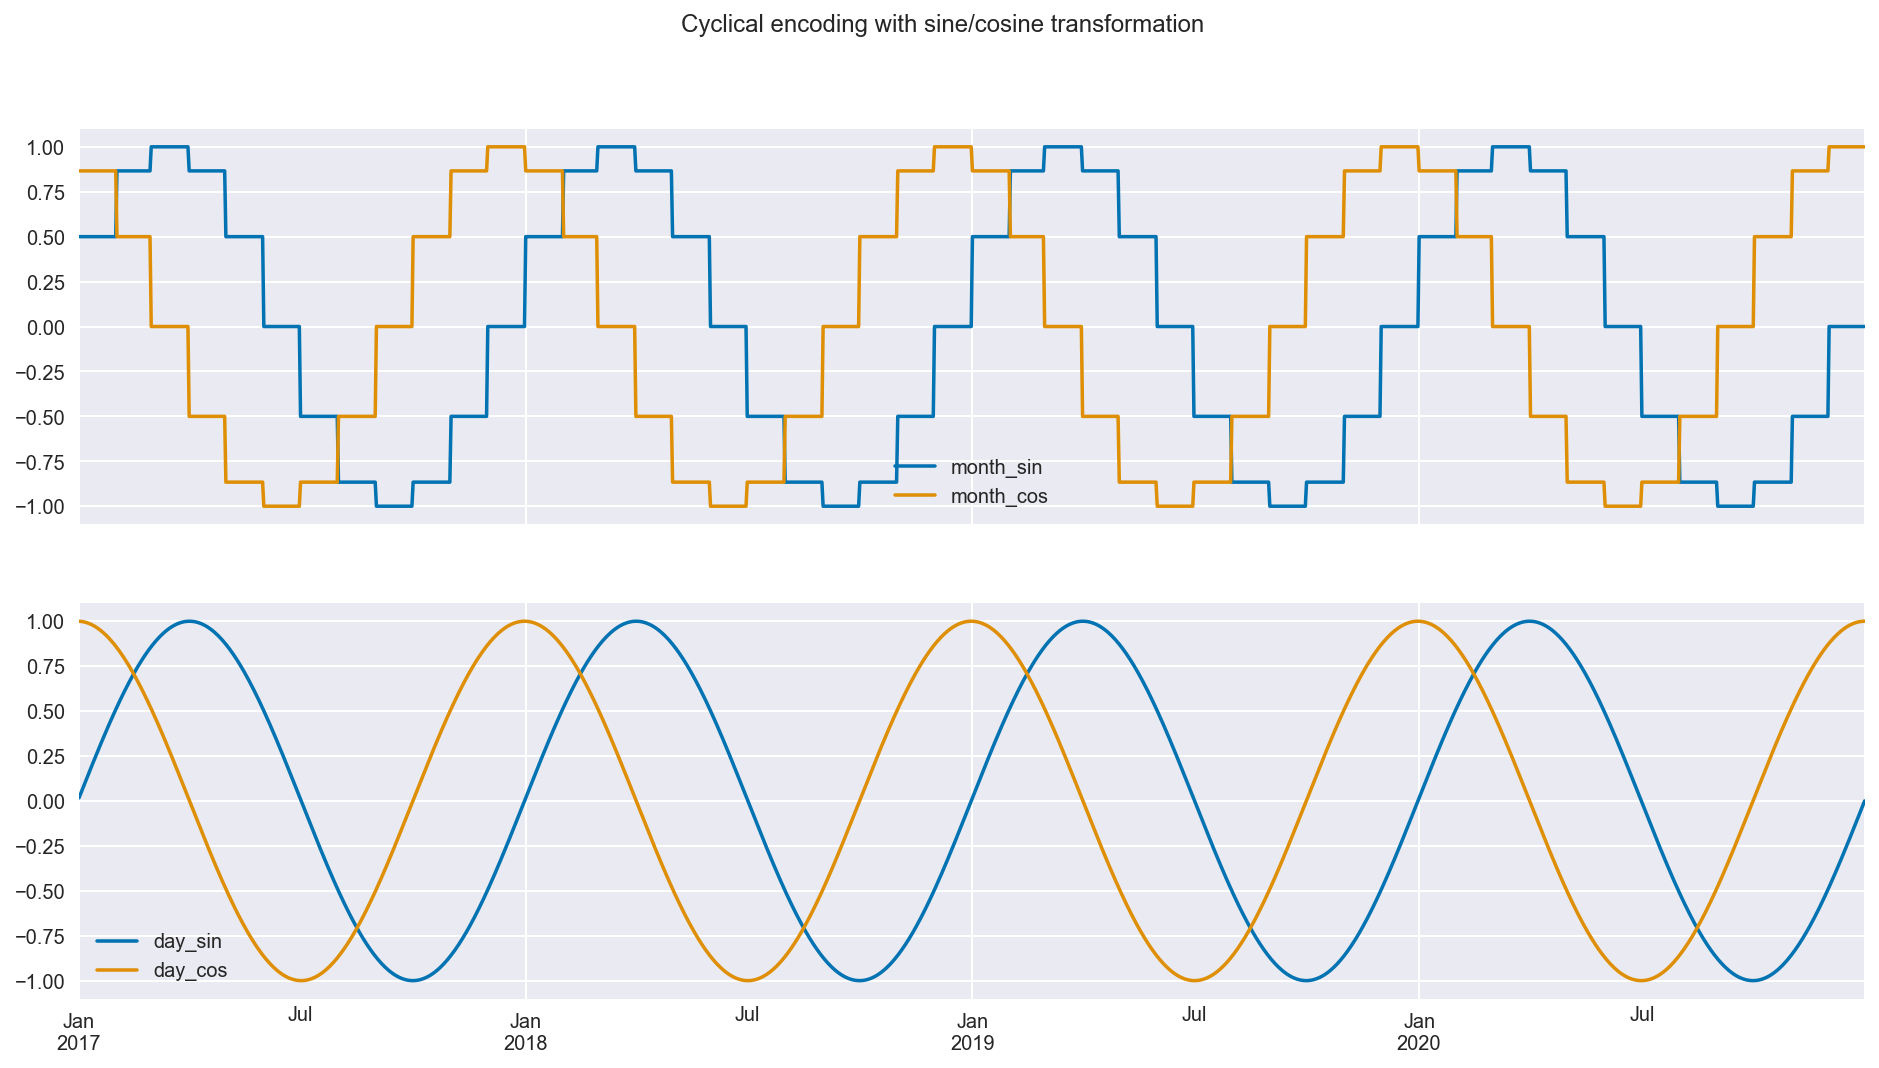

In [21]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16,8))
X_2[["month_sin", "month_cos"]].plot(ax=ax[0])
X_2[["day_sin", "day_cos"]].plot(ax=ax[1])
plt.suptitle("Cyclical encoding with sine/cosine transformation");

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


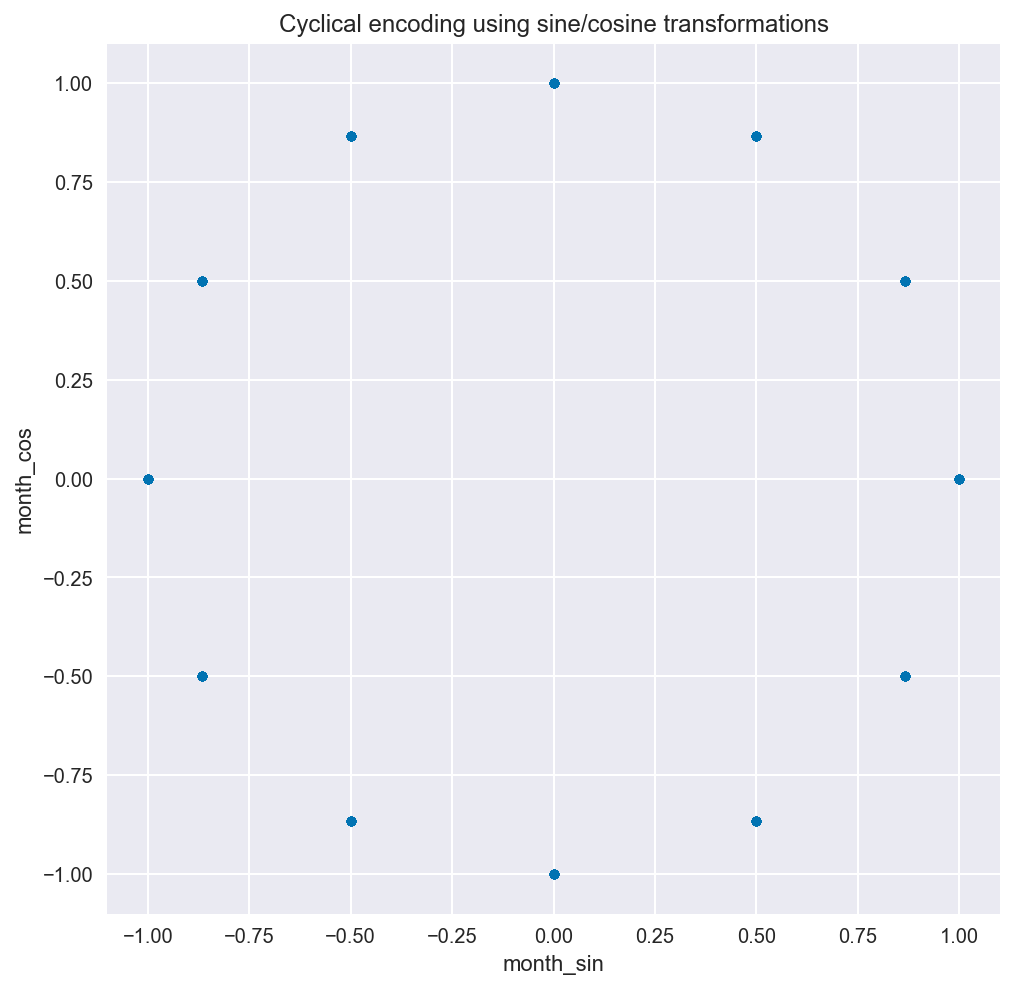

In [22]:
X_2[X_2.index.year == 2017].plot(kind="scatter", 
                                 x="month_sin", 
                                 y="month_cos", 
                                 figsize=(8, 8),
                                 title="Cyclical encoding using sine/cosine transformations");

In [23]:
X_2[X_2.index.year == 2017]

,day_nr,day_of_year,month,month_sin,month_cos,day_sin,day_cos
2017-01-01,0,1,1,5.000000e-01,0.866025,1.721336e-02,0.999852
2017-01-02,1,2,1,5.000000e-01,0.866025,3.442161e-02,0.999407
2017-01-03,2,3,1,5.000000e-01,0.866025,5.161967e-02,0.998667
2017-01-04,3,4,1,5.000000e-01,0.866025,6.880243e-02,0.997630
2017-01-05,4,5,1,5.000000e-01,0.866025,8.596480e-02,0.996298
...,...,...,...,...,...,...,...
2017-12-27,360,361,12,-2.449294e-16,1.000000,-6.880243e-02,0.997630
2017-12-28,361,362,12,-2.449294e-16,1.000000,-5.161967e-02,0.998667
2017-12-29,362,363,12,-2.449294e-16,1.000000,-3.442161e-02,0.999407
2017-12-30,363,364,12,-2.449294e-16,1.000000,-1.721336e-02,0.999852


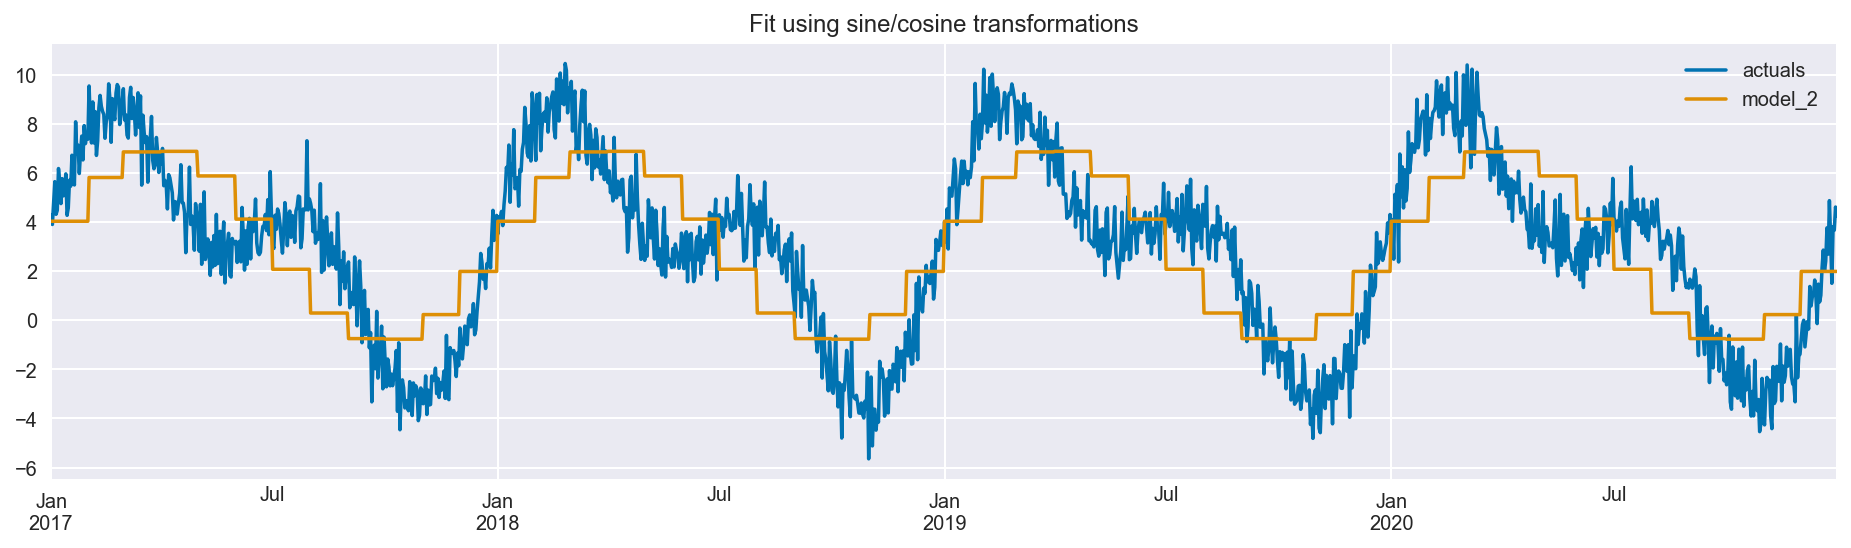

In [14]:
X_2 = X_2[["month_sin", "month_cos"]]
results_df["model_2"] = LinearRegression().fit(X_2, y).predict(X_2)
results_df[["actuals", "model_2"]].plot(figsize=(16,4), 
                                        title="Fit using sine/cosine transformations");

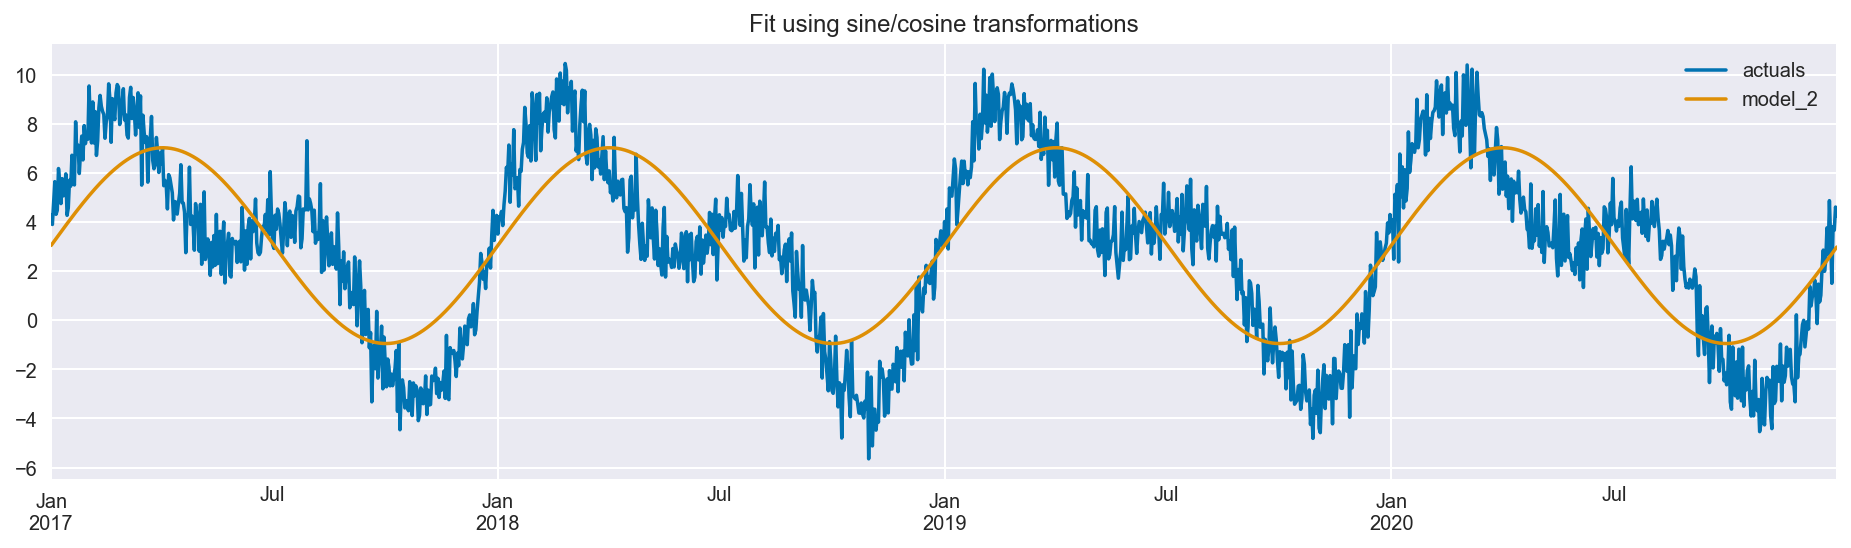

In [24]:
X_2 = X_2[["day_sin", "day_cos"]]
results_df["model_2"] = LinearRegression().fit(X_2, y).predict(X_2)
results_df[["actuals", "model_2"]].plot(figsize=(16,4), 
                                        title="Fit using sine/cosine transformations");

### Approach 3: Radial Basis Functions

In [6]:
rbf = RepeatingBasisFunction(n_periods=12,
                             column="day_of_year",
                             input_range=(1,365),
                             remainder="drop")
rbf.fit(X)
X_3 = pd.DataFrame(index=X.index, 
                   data=rbf.transform(X))

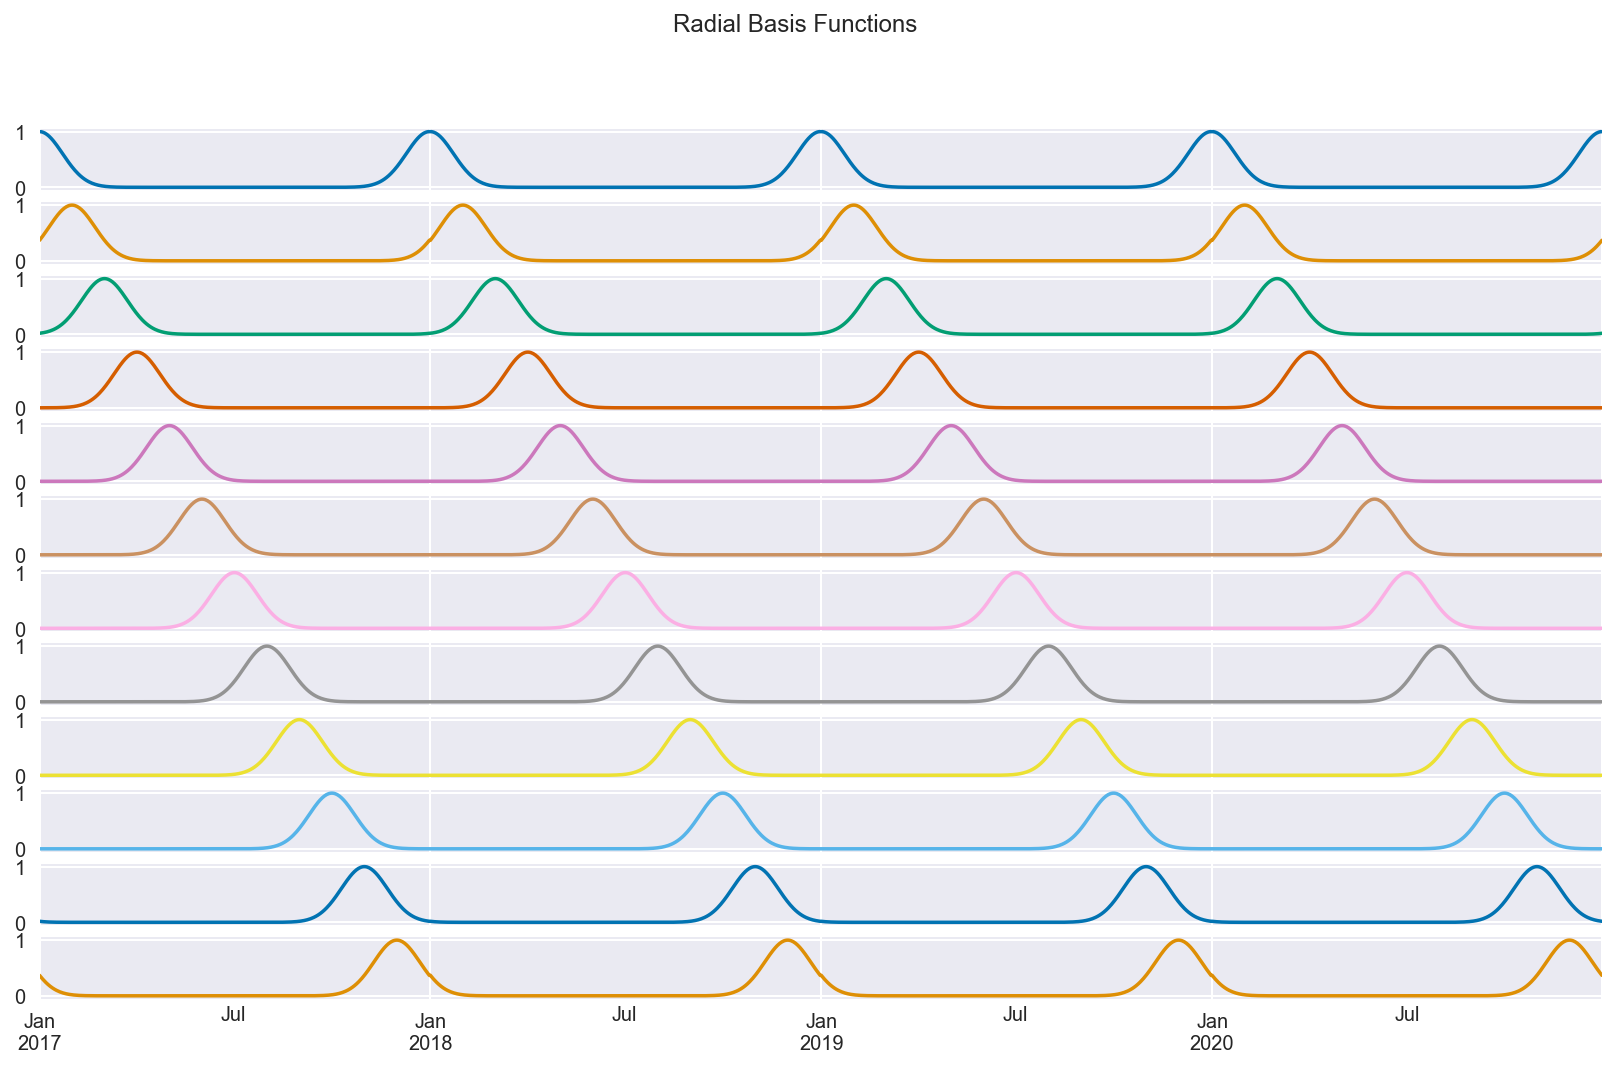

In [8]:
X_3.plot(subplots=True, figsize=(14, 8), 
         sharex=True, title="Radial Basis Functions", 
         legend=False);


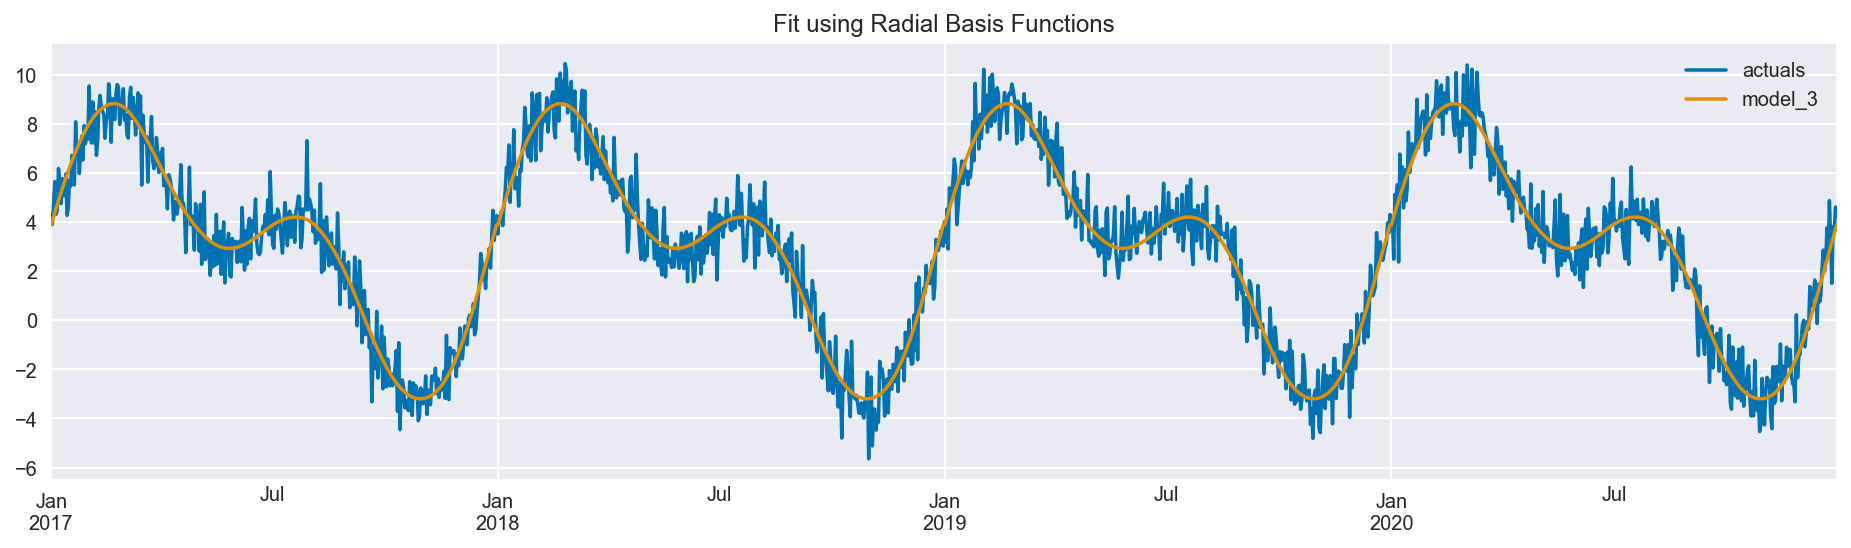

In [59]:
results_df["model_3"] = LinearRegression().fit(X_3, y).predict(X_3)
results_df[["actuals", "model_3"]].plot(figsize=(16,4), 
                                        title="Fit using Radial Basis Functions");

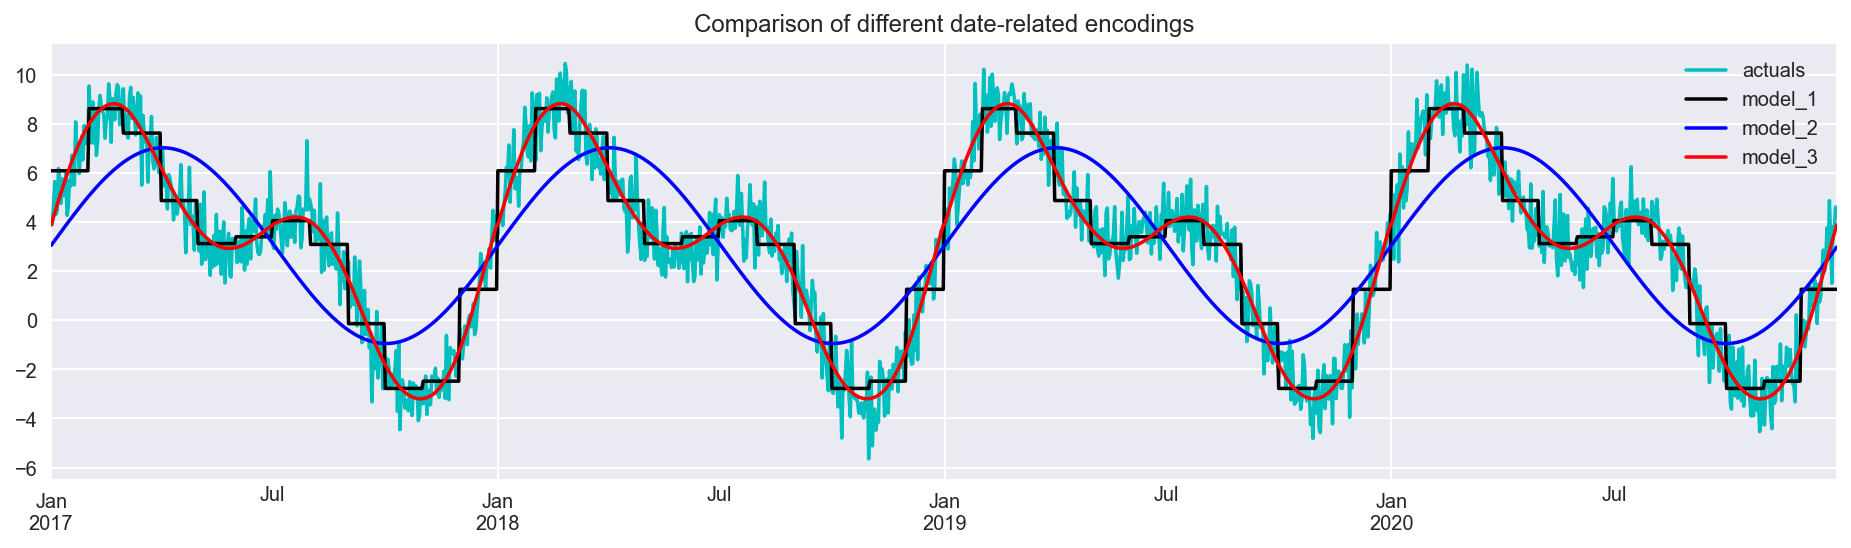

In [60]:
results_df.plot(title="Comparison of different date-related encodings",
                figsize=(16,4), 
                color = ["c", "k", "b", "r"]);